In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

In [165]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
import random
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [166]:
class CFG:
  exp = "exp19"
  seed = 71
  fold = 10

CONFIG = CFG()

In [167]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [168]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

# 処理済みデータ読み込み

In [169]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [170]:
df_train_org = df_train.copy()

In [171]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-21 21:38:07.200,2021-09-21 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-21 21:38:15.600,2021-09-21 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-21 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:21.200,NaT,1.0,14,14


In [172]:
df_train_0=df_train[df_train.event_type !=3].reset_index(drop=True)
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [173]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [174]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_train.columns=["customer_id","time_duration_frame","in_time"]
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test.columns=["customer_id","time_duration_frame","in_time"]

# shopper area time
df_sub=df_train[df_train.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_train = df_sub[~df_sub.num_touch.isnull()]
df_area_train =df_area_train.drop_duplicates()
df_area_train = df_area_train[["customer_id","area_id","time_duration"]]
df_area_train.columns=["customer_id","area_id","time_duration_area"]

df_sub=df_test[df_test.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_test = df_sub[~df_sub.num_touch.isnull()]
df_area_test =df_area_test.drop_duplicates()
df_area_test = df_area_test[["customer_id","area_id","time_duration"]]
df_area_test.columns=["customer_id","area_id","time_duration_area"]

In [175]:
df_area_train

,customer_id,area_id,time_duration_area
1,20201026-010001,1.0,6.2
2,20201026-010001,1.0,6.2
4,20201026-010002,1.0,7.8
5,20201026-010002,1.0,7.8
7,20201026-010003,1.0,14.0
...,...,...,...
13475,20201101-120054,1.0,11.2
13476,20201101-120054,1.0,11.2
13477,20201101-120054,1.0,11.2
13479,20201101-120055,5.0,13.0


In [176]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,df_area_train,on="customer_id")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time', 'buy_flag'])
df_train = df_train.drop_duplicates()

df_test = pd.merge(df_test3,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,df_area_test,on="customer_id")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area','in_time'])
df_test = df_test.drop_duplicates()

In [177]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


In [178]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,7.2,2021-09-21 08:07:13.000
2,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,7.2,2021-09-21 08:07:13.000
4,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,8,12,21.2,4.8,2021-09-21 08:10:32.600
7,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,9,11,21.2,4.8,2021-09-21 08:10:32.600
10,20201026-010008,2020/10/26,man,40's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,12,8,21.2,4.8,2021-09-21 08:10:32.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,2020/11/1,man,20's,Young,優しい君500ml,ラボラトリー,2.0,9,19,28.6,16.8,2021-09-21 21:36:35.800
14618,20201101-120052,2020/11/1,man,20's,Young,ほっと一息500ml,エターナル,2.0,11,16,28.6,16.8,2021-09-21 21:36:35.800
14622,20201101-120052,2020/11/1,man,20's,Young,職人の力500ml,フューチャー,2.0,21,6,28.6,16.8,2021-09-21 21:36:35.800
14626,20201101-120056,2020/11/1,woman,30's,Young,匠の果実500ml,エターナル,1.0,15,7,22.6,15.2,2021-09-21 21:47:14.200


In [179]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0


In [180]:
df_train.buy_flag.value_counts()

1.0    4976
0.0    1798
Name: buy_flag, dtype: int64

# 前処理

## 容量のカラム追加

In [181]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [182]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


## 入時間の設定

In [183]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time_hour"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time_min"] = df_train["in_time"].apply(lambda x: x.minute)
df_train=df_train.drop(columns="in_time")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time_hour"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time_min"] = df_test["in_time"].apply(lambda x: x.minute)
df_test=df_test.drop(columns="in_time")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())

In [184]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
2,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
4,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
6,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
8,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
26419,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
26422,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
26425,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [185]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,7.2,8,7
2,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,7.2,8,7
4,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,8,12,21.2,4.8,8,10
7,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,9,11,21.2,4.8,8,10
10,20201026-010008,0,man,40's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,12,8,21.2,4.8,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,6,man,20's,Young,優しい君500ml,500,ラボラトリー,2.0,9,19,28.6,16.8,21,36
14618,20201101-120052,6,man,20's,Young,ほっと一息500ml,500,エターナル,2.0,11,16,28.6,16.8,21,36
14622,20201101-120052,6,man,20's,Young,職人の力500ml,500,フューチャー,2.0,21,6,28.6,16.8,21,36
14626,20201101-120056,6,woman,30's,Young,匠の果実500ml,500,エターナル,1.0,15,7,22.6,15.2,21,47


## 滞在時間での切り捨て

In [186]:
df_train.groupby("buy_flag").time_duration_frame.mean()

buy_flag
0.0    89.870189
1.0    47.108842
Name: time_duration_frame, dtype: float64

In [187]:
def time_duration_revise(x,col):
  if x >= 500:
    x=df_test[col].mean()
    return x
  else:
    return x

In [188]:
#外れ値保管
df_test["1in_3in"]=df_test["1in_3in"].apply(lambda x:time_duration_revise(x,"1in_3in"))
df_test["3in_1out"]=df_test["3in_1out"].apply(lambda x:time_duration_revise(x,"3in_1out"))
df_train=df_train[df_train["3in_1out"] < 500].reset_index(drop=True)

#Frame time cut for positive
del_df_train = df_train[(df_train.time_duration_frame > 100) & (df_train.buy_flag == 1)]
others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

#Frame time cut all
df_train=df_train[df_train["time_duration_frame"] < df_test["time_duration_frame"].max()].reset_index(drop=True)
df_train=df_train[df_train["time_duration_area"] < df_test["time_duration_area"].max()].reset_index(drop=True)
df_train=df_train[df_train["1in_3in"] < df_test["1in_3in"].max()].reset_index(drop=True)
df_train=df_train[df_train["3in_1out"] < df_test["3in_1out"].max()].reset_index(drop=True)


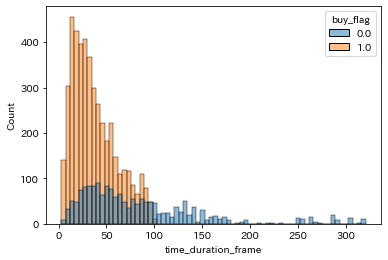

In [189]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

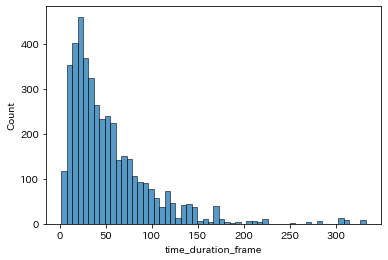

In [190]:
sns.histplot(data=df_test, x="time_duration_frame")

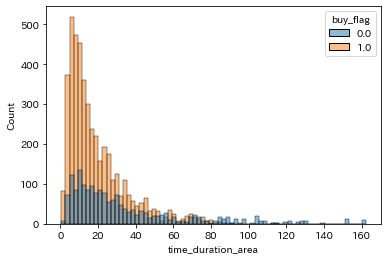

In [191]:
sns.histplot(data=df_train, x="time_duration_area",hue="buy_flag")

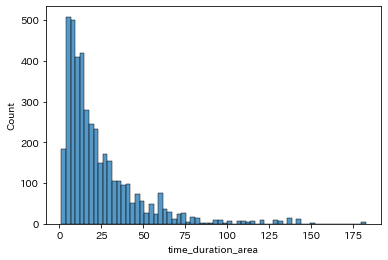

In [192]:
sns.histplot(data=df_test, x="time_duration_area")

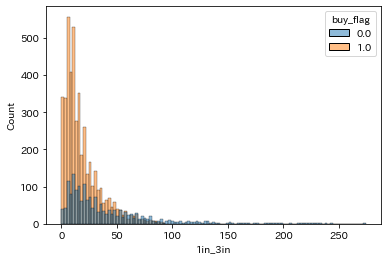

In [193]:
sns.histplot(data=df_train, x="1in_3in",hue="buy_flag")

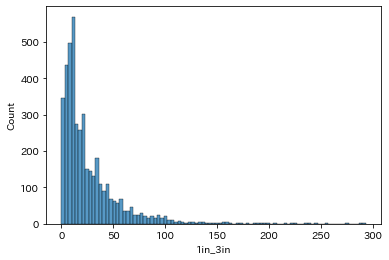

In [194]:
sns.histplot(data=df_test, x="1in_3in")

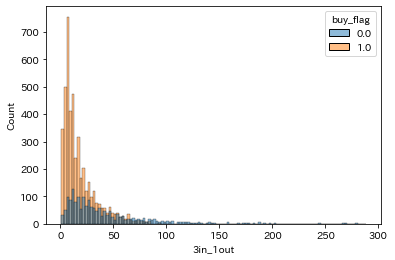

In [195]:
sns.histplot(data=df_train, x="3in_1out",hue="buy_flag")

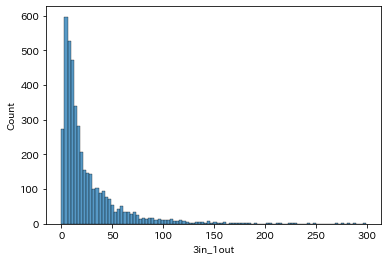

In [196]:
sns.histplot(data=df_test, x="3in_1out")

In [197]:
df_train.buy_flag.value_counts()

1.0    4571
0.0    1745
Name: buy_flag, dtype: int64

## オーバーサンプリング

In [198]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
6312,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
6313,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
6314,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [199]:
adasyn = BorderlineSMOTE(random_state = CONFIG.seed)
#sample_cols=["1in_3in", "3in_1out","time_duration_frame","time_duration_area","in_time_hour","in_time_min"]
sample_cols=["time_duration_frame","time_duration_area"]

#対象カラムのオーバーサンプリング
X, y = adasyn.fit_resample(df_train[sample_cols], df_train['buy_flag'])
df_oversample = pd.DataFrame(X, columns = sample_cols)
df_oversample["buy_flag"]=y
add_samples=df_oversample.iloc[list(df_train.index)[-1]+1:]

#buy_flag=0のrow複製
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [200]:
#オーバサンプリングした数値の上書き
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

In [201]:
for i in sample_cols:
  add_df[i]=add_samples[i].values

In [202]:
add_df

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
5542,20201101-050120,6,woman,50's,Middle,スペシャルライフ500ml,500,フューチャー,3.0,10,18,24.683086,17.947777,0.0,13,40
2073,20201028-040136,2,man,10's,Teen,ワイルドオレ500ml,500,ラボラトリー,2.0,28,30,53.600000,5.800000,0.0,16,19
4598,20201031-040088,5,man,20's,Young,かろやかオレンジ425ml,425,ラボラトリー,3.0,44,11,77.879222,7.121426,0.0,15,37
2393,20201028-070108,2,woman,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,51,9,89.750913,18.033498,0.0,20,20
185,20201026-020024,0,woman,60's,Senior,電撃蜜柑410ml,410,レジェンド,3.0,17,53,81.200000,40.000000,0.0,11,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,20201029-070104,3,man,20's,Young,イエローサイダー500ml,500,トップモード,3.0,6,36,37.000660,6.804621,0.0,20,11
4755,20201031-050163,5,woman,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,20,12,32.324523,17.962261,0.0,16,52
2880,20201029-040158,3,man,10's,Teen,スペシャルライフ500ml,500,フューチャー,2.0,49,222,35.750543,24.851628,0.0,16,21
3387,20201030-020060,4,woman,40's,Middle,おそば屋さんのお茶500ml,500,イッツ園,1.0,11,54,11.285994,10.600000,0.0,11,32


In [203]:
df_train = pd.concat([df_train,add_df],axis=0).reset_index(drop=True)

In [204]:
df_train.buy_flag.value_counts()

0.0    4571
1.0    4571
Name: buy_flag, dtype: int64

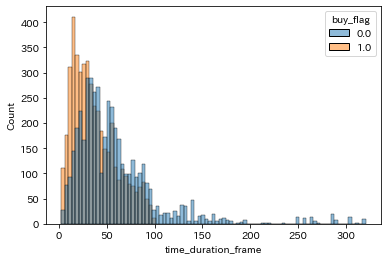

In [205]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

In [206]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201029-070104,3,man,20's,Young,イエローサイダー500ml,500,トップモード,3.0,6,36,37.000660,6.804621,0.0,20,11
9138,20201031-050163,5,woman,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,20,12,32.324523,17.962261,0.0,16,52
9139,20201029-040158,3,man,10's,Teen,スペシャルライフ500ml,500,フューチャー,2.0,49,222,35.750543,24.851628,0.0,16,21
9140,20201030-020060,4,woman,40's,Middle,おそば屋さんのお茶500ml,500,イッツ園,1.0,11,54,11.285994,10.600000,0.0,11,32


## Area外滞在時間/Area滞在時間率

In [207]:
df_train["time_frameout"] = df_train["time_duration_frame"] - df_train["time_duration_area"]
df_test["time_frameout"] = df_test["time_duration_frame"] - df_test["time_duration_area"]

In [208]:
df_train["time_area_rate"] = df_train["time_duration_area"] / df_train["time_duration_frame"]
df_test["time_area_rate"] = df_test["time_duration_area"] / df_test["time_duration_frame"]

In [209]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2,5.800000,0.573529
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2,5.800000,0.573529
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2,0.200000,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201029-070104,3,man,20's,Young,イエローサイダー500ml,500,トップモード,3.0,6,36,37.000660,6.804621,0.0,20,11,30.196039,0.183905
9138,20201031-050163,5,woman,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,20,12,32.324523,17.962261,0.0,16,52,14.362261,0.555685
9139,20201029-040158,3,man,10's,Teen,スペシャルライフ500ml,500,フューチャー,2.0,49,222,35.750543,24.851628,0.0,16,21,10.898915,0.695140
9140,20201030-020060,4,woman,40's,Middle,おそば屋さんのお茶500ml,500,イッツ園,1.0,11,54,11.285994,10.600000,0.0,11,32,0.685994,0.939217


## ターゲットエンコーディング（購入率）

In [210]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [211]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time_hour']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

In [212]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.537838,0.485871,0.562720,0.570306,0.730375,0.556647,0.643192,0.533645,0.533643
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.537838,0.485871,0.562720,0.570306,0.730375,0.556647,0.643192,0.533645,0.533643
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.400000,8.200000,1.0,8,2,11.200000,0.422680,0.474522,0.485871,0.562720,0.570306,0.730375,0.556647,0.643192,0.533645,0.533643
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.000000,7.800000,1.0,8,43,35.200000,0.181395,0.474522,0.485871,0.562720,0.570306,0.730375,0.556647,0.643192,0.533645,0.533643
4,20201026-010050,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,16,7,23.800000,12.200000,1.0,8,50,11.600000,0.512605,0.537838,0.516457,0.562720,0.570306,0.730375,0.556647,0.643192,0.533645,0.533643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-040037,5,woman,30's,Young,水玉ウォーター500ml,500,カルシウムウェイ,2.0,12,10,22.600000,4.200000,1.0,15,19,18.400000,0.185841,0.424570,0.485871,0.562720,0.570306,0.414634,0.522949,0.414634,0.460278,0.396996
9138,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,57.200000,5.600000,0.0,15,4,51.600000,0.097902,0.523140,0.516457,0.593129,0.555250,0.061135,0.142512,0.079734,0.460278,0.396996
9139,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,11,45,57.200000,5.600000,1.0,15,4,51.600000,0.097902,0.523140,0.516457,0.593129,0.555250,0.061135,0.142512,0.079734,0.460278,0.396996
9140,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,16.000000,10.224005,0.0,15,4,5.775995,0.639000,0.523140,0.516457,0.593129,0.555250,0.061135,0.142512,0.079734,0.460278,0.396996


In [213]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,11.0,19.8,7.2,8,7,12.6,0.363636,0.537838,0.516457,0.522227,0.555250,0.848214,0.556647,0.643192,0.533645,0.533643
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,9.0,19.8,7.2,8,7,12.6,0.363636,0.537838,0.516457,0.522227,0.555250,0.848214,0.556647,0.643192,0.533645,0.533643
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,4.0,14.4,5.2,8,1,9.2,0.361111,0.535554,0.516457,0.522227,0.555250,0.848214,0.556647,0.643192,0.533645,0.533643
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,10.0,18.4,7.2,8,7,11.2,0.391304,0.516026,0.516457,0.522227,0.555250,0.848214,0.556647,0.643192,0.533645,0.533643
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,8.0,18.4,7.2,8,7,11.2,0.391304,0.516026,0.516457,0.522227,0.555250,0.848214,0.556647,0.643192,0.533645,0.533643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,20201101-050032,6,woman,40's,Middle,黒の息吹500ml,500,モーリーフラフト,2.0,51.0,13.0,64.8,37.8,13,13,27.0,0.583333,0.523140,0.485871,0.522227,0.555250,0.452991,0.522949,0.338843,0.460278,0.565436
4290,20201101-050032,6,woman,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44.0,20.0,64.8,37.8,13,13,27.0,0.583333,0.523140,0.485871,0.522227,0.555250,0.232000,0.296482,0.338843,0.460278,0.565436
4291,20201029-030110,3,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,36.0,13.0,50.0,35.8,13,59,14.2,0.716000,0.535554,0.485871,0.562720,0.570306,0.232000,0.296482,0.338843,0.460278,0.565436
4292,20201031-030018,5,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,14.0,11.0,25.8,10.8,13,5,15.0,0.418605,0.424570,0.485871,0.562720,0.570306,0.232000,0.296482,0.338843,0.460278,0.565436


## カテゴリーのエンコーディング

In [214]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [215]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [216]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [217]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

# モデル作成

In [218]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [219]:
def fit_xgb(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = xgb.XGBClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)

        #print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        #pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [220]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective': "binary:logistic",
    'max_depth': 100,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x=df_train_encoded.drop(columns=["customer_id"])
train_x = train_x.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_xgb(train_x.values, train_y, cv, params=params)

[0]	validation_0-error:0.206557
Will train until validation_0-error hasn't improved in 50 rounds.
[50]	validation_0-error:0.161749
[100]	validation_0-error:0.145355
[150]	validation_0-error:0.139891
Stopping. Best iteration:
[116]	validation_0-error:0.134426

fit fold=1 13.169[s]
AUC 0 Score: 0.9104
[0]	validation_0-error:0.209836
Will train until validation_0-error hasn't improved in 50 rounds.
[50]	validation_0-error:0.162842
[100]	validation_0-error:0.153005
[150]	validation_0-error:0.147541
[200]	validation_0-error:0.137705
[250]	validation_0-error:0.131148
Stopping. Best iteration:
[222]	validation_0-error:0.127869

fit fold=2 22.113[s]
AUC 1 Score: 0.9411
[0]	validation_0-error:0.171772
Will train until validation_0-error hasn't improved in 50 rounds.
[50]	validation_0-error:0.148796
[100]	validation_0-error:0.134573
[150]	validation_0-error:0.125821
[200]	validation_0-error:0.119256
[250]	validation_0-error:0.110503
[300]	validation_0-error:0.110503
Stopping. Best iteration:
[26

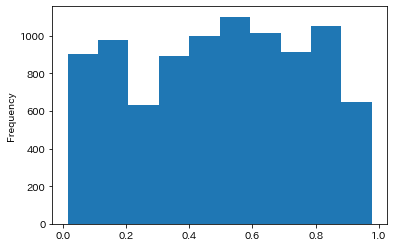

In [221]:
oof["pred_prob"].plot(kind="hist")

In [222]:
df_train_encoded[["customer_id"]]

,customer_id
0,20201026-010001
1,20201026-010001
2,20201027-010002
3,20201027-010049
4,20201026-010050
...,...
9137,20201031-040037
9138,20201101-070012
9139,20201101-070012
9140,20201101-070012


In [223]:
train_pred_1=pd.concat([oof[["pred_prob","y"]],df_train_encoded[["customer_id"]]],axis=1).set_index("customer_id")

In [224]:
a=df_train_org[df_train_org.event_type!=3].customer_id.unique()
b=df_train_org[df_train_org.event_type==3].customer_id.unique()
others_list=list(set(list(a)) ^ set(list(b)) )

train_pred_0 = pd.DataFrame()
train_pred_0["customer_id"] = others_list
train_pred_0["pred_prob"] = 0
train_pred_0["y"] = 0
train_pred_0=train_pred_0.set_index("customer_id")
train_pred=pd.concat([train_pred_1,train_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [225]:
score = roc_auc_score(train_pred["y"], train_pred["pred_prob"]) 
print('Train | AUC Score: {:.4f}'.format(score))

Train | AUC Score: 0.9496


## 学習結果

In [226]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

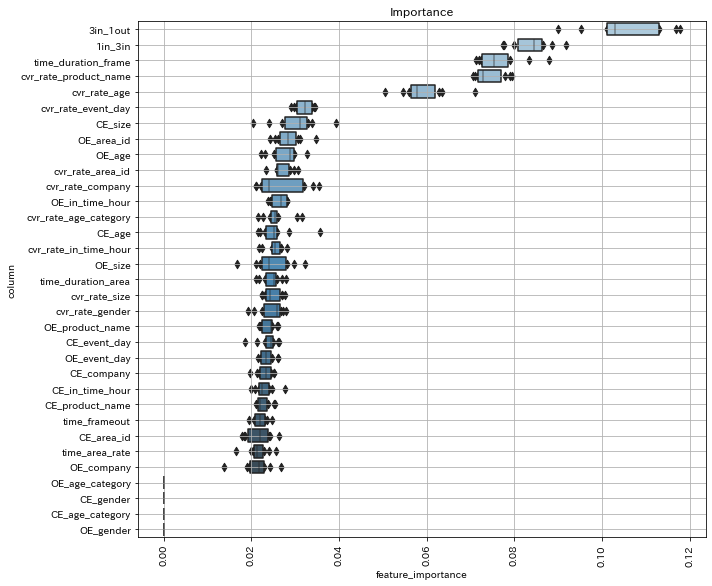

In [227]:
fig, ax = visualize_importance(models, train_x)

In [228]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

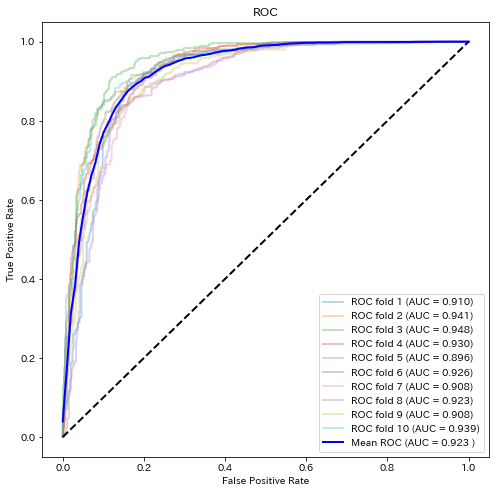

In [229]:
visulalize_roc(oof,CONFIG.fold)

In [230]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

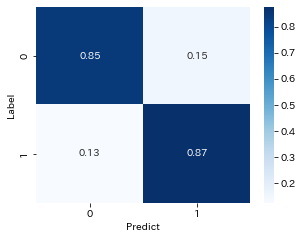

In [231]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [232]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]
#pred = np.where(pred < 0.5, 0, 1)

In [233]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [234]:
submission_pred = submission_pred.groupby("customer_id").max()

In [235]:
submission_pred

,buy_proba
customer_id,
20201026-010006,0.780050
20201026-010008,0.761965
20201026-010011,0.769208
20201026-010012,0.778472
20201026-010018,0.587690
...,...
20201101-120031,0.788863
20201101-120033,0.746836
20201101-120051,0.632521


In [236]:
#submission_pred=submission_pred.groupby("customer_id").mean().reset_index()
#pred = np.where( submission_pred["buy_proba"].values<0.5, 0, 1)
#submission_pred["buy_proba"]=pred
#submission_pred=submission_pred.set_index("customer_id")

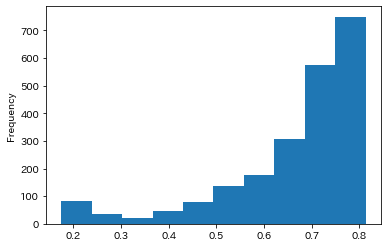

In [237]:
submission_pred["buy_proba"].plot(kind="hist")

In [238]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [239]:
submission_pred_0

,buy_proba
customer_id,
20201031-010196,0
20201029-040082,0
20201027-040108,0
20201026-010179,0
20201031-050019,0
...,...
20201028-040085,0
20201027-040021,0
20201101-070214,0


In [240]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [241]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.780050
1,20201026-010008,0.761965
2,20201026-010011,0.769208
3,20201026-010012,0.778472
4,20201026-010018,0.587690
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.632521
4528,20201101-120052,0.708390


In [242]:
submission_pred_all.buy_proba.value_counts()

0.000000    2326
0.176359       2
0.775038       2
0.697952       1
0.654230       1
            ... 
0.770926       1
0.342496       1
0.182967       1
0.373748       1
0.174814       1
Name: buy_proba, Length: 2203, dtype: int64

In [243]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)